Duración de la simulación:  4.052185535430908
0 errores, para un BER de 0.0000.


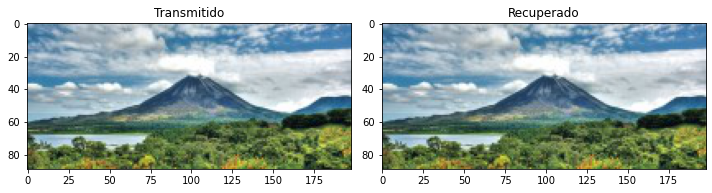

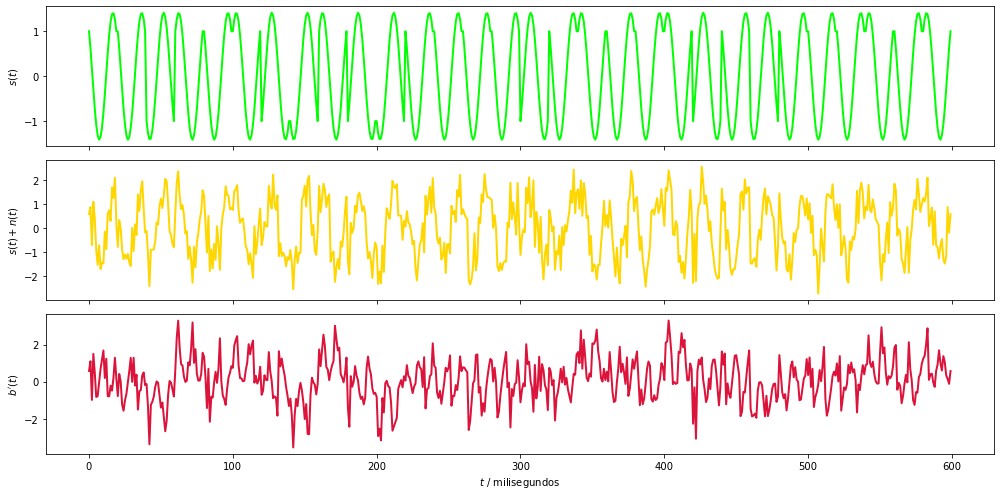

In [6]:
# CÓDIGO 4.1

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import time


def fuente_info(imagen):

    img = Image.open(imagen)
    
    return np.array(img)



def rgb_a_bit(imagen):

    # Obtener las dimensiones de la imagen
    x, y, z = imagen.shape
    
    # Número total de pixeles
    n_pixeles = x * y * z

    # Convertir la imagen a un vector unidimensional de n_pixeles
    pixeles = np.reshape(imagen, n_pixeles)

    # Convertir los canales a base 2
    bits = [format(pixel,'08b') for pixel in pixeles]
    bits_Rx = np.array(list(''.join(bits)))

    
    
    return bits_Rx.astype(int)




def modulador_I(bits, fc, mpp):

    
   
    Reacomodo_bits = bits.reshape(len(bits)//2, 2)
    
    
    # 1. Parámetros de la 'señal' de información (bits)
    N = len(Reacomodo_bits) # Cantidad de bits

    # 2. Construyendo un periodo de la señal portadora c(t)
    Tc = 1 / fc  # periodo [s]
    t_periodo = np.linspace(0, Tc, mpp)
    portadoraI = np.cos(2*np.pi*fc*t_periodo)


    # 3. Inicializar la señal modulada s(t)
    t_simulacion = np.linspace(0, N*Tc, N*mpp) 
    senal_TxI = np.zeros(t_simulacion.shape)
    moduladora = np.zeros(t_simulacion.shape)  # señal de información
 
    # 4. Asignar las formas de onda según los bits (BPSK)
    for i, bit in enumerate(Reacomodo_bits):
        if Reacomodo_bits[i,0] == 1:
            senal_TxI[i*mpp : (i+1)*mpp] = portadoraI
            moduladora[i*mpp : (i+1)*mpp] = 1
        else:
            senal_TxI[i*mpp : (i+1)*mpp] = portadoraI * -1
            moduladora[i*mpp : (i+1)*mpp] = 0
    
    # 5. Calcular la potencia promedio de la señal modulada
    Pm_I = (1 / (N*Tc)) * np.trapz(pow(senal_TxI, 2), t_simulacion)
    
    return senal_TxI, Pm_I, portadoraI, moduladora, Tc, N, t_simulacion



#-----------------------------------------------------------------------




def modulador_Q(bits, fc, mpp):

    
    Reacomodo_bits = bits.reshape(len(bits)//2, 2)
    
    
    # 1. Parámetros de la 'señal' de información (bits)
    N = len(Reacomodo_bits) # Cantidad de bits

    # 2. Construyendo un periodo de la señal portadora c(t)
    Tc = 1 / fc  # periodo [s]
    t_periodo = np.linspace(0, Tc, mpp)
    portadoraQ = np.sin(2*np.pi*fc*t_periodo)


    # 3. Inicializar la señal modulada s(t)
    t_simulacion = np.linspace(0, N*Tc, N*mpp) 
    senal_TxQ = np.zeros(t_simulacion.shape)
    moduladora = np.zeros(t_simulacion.shape)  # señal de información
 
    # 4. Asignar las formas de onda según los bits (BPSK)
    for i, bit in enumerate(Reacomodo_bits):
        if Reacomodo_bits[i,1] == 1:
            senal_TxQ[i*mpp : (i+1)*mpp] = portadoraQ
            moduladora[i*mpp : (i+1)*mpp] = 1
        else:
            senal_TxQ[i*mpp : (i+1)*mpp] = portadoraQ * -1
            moduladora[i*mpp : (i+1)*mpp] = 0
    
    # 5. Calcular la potencia promedio de la señal modulada
    Pm_Q = (1 / (N*Tc)) * np.trapz(pow(senal_TxQ, 2), t_simulacion)
    
    return senal_TxQ, Pm_Q, portadoraQ, moduladora 


# Realizamos la suma de las dos señales
def Suma_senal_Tx(Tc, N, t_simulacion, senal_TxI, senal_TxQ):

    senal_Tx = senal_TxI + senal_TxQ

    Pm = (1 / (N*Tc)) * np.trapz(pow(senal_Tx, 2), t_simulacion)
    
    return senal_Tx, Pm  


#-------------------------------------------------------------


def canal_ruidoso(senal_Tx, Pm, SNR):

    # Potencia del ruido generado por el canal
    Pn = Pm / pow(10, SNR/10)

    # Generando ruido auditivo blanco gaussiano
    ruido = np.random.normal(0, np.sqrt(Pn), senal_Tx.shape)

    # Señal distorsionada por el canal ruidoso
    senal_Rx = senal_Tx + ruido

    return senal_Rx



#---------------------------------------------------------------------




def demodulador(senal_Rx, portadoraI, portadoraQ, mpp):

    # Cantidad de muestras en senal_Rx
    M = len(senal_Rx)

    # Cantidad de bits en transmisión
    N = int(M / mpp)

    # Vector para bits obtenidos por la demodulación
    bits_RxI = np.zeros(N)
    bits_RxQ = np.zeros(N)
    bits_Rx  = np.zeros(2*N)

    # Vector para la señal demodulada
    senal_demodulada = np.zeros(M)

    
    

    # Demodulación
    for i in range(N):
        # Producto interno de dos funciones
        productoI = senal_Rx[i*mpp : (i+1)*mpp] * portadoraI
        productoQ = senal_Rx[i*mpp : (i+1)*mpp] * portadoraQ
        
        
        senal_demodulada[i*mpp : (i+1)*mpp] = productoI + productoQ

        
        EpI = np.sum(productoI) 
        EpQ = np.sum(productoQ) 

        

        # Criterio de decisión por detección de energía
        
        if EpI > 0:
            bits_RxI[i] = 1
        else:
            bits_RxI[i] = 0
            
            
        if EpQ > 0:
            bits_RxQ[i] = 1
        else:
            bits_RxQ[i] = 0
            
    for i, bit_numero_1 in enumerate(bits_RxI):
            bits_Rx[2*i] = bit_numero_1 
        
        
    for j, bit_numero_2 in enumerate(bits_RxQ):
            bits_Rx[2*j+1] = bit_numero_2
            

    return bits_Rx.astype(int), senal_demodulada





#-------------------------------------------------------------------------

def bits_a_rgb(bits_Rx, dimensiones):

    # Cantidad de bits
    N = len(bits_Rx)

    # Se reconstruyen los canales RGB
    bits = np.split(bits_Rx, N / 8)

    # Se decofican los canales:
    canales = [int(''.join(map(str, canal)), 2) for canal in bits]
    pixeles = np.reshape(canales, dimensiones)

    return pixeles.astype(np.uint8)


#--------------------------------------------------------------------------



# Parámetros
fc = 5000  # frecuencia de la portadora
mpp = 20   # muestras por periodo de la portadora
SNR = 5    # relación señal-a-ruido del canal

# Iniciar medición del tiempo de simulación
inicio = time.time()

# 1. Importar y convertir la imagen a trasmitir
imagen_Tx = fuente_info('arenal.jpg')
dimensiones = imagen_Tx.shape

# 2. Codificar los pixeles de la imagen
bits_Tx = rgb_a_bit(imagen_Tx)



# 3. Modular la cadena de bits usando el esquema QPSK



senal_TxQ, Pm, portadoraI, moduladora_I, Tc, N, t_simulacion = modulador_I(bits_Tx, fc, mpp)

senal_TxI, Pm, portadoraQ, moduladora_Q = modulador_Q(bits_Tx, fc, mpp)


senal_Tx, Pm = Suma_senal_Tx(Tc, N, t_simulacion, senal_TxI, senal_TxQ)



# 4. Se transmite la señal modulada, por un canal ruidoso
senal_Rx = canal_ruidoso(senal_Tx, Pm, SNR)



# 5. Se desmodula la señal recibida del canal
bits_Rx, senal_demodulada = demodulador(senal_Rx, portadoraI, portadoraQ, mpp)



# 6. Se visualiza la imagen recibida 
imagen_Rx = bits_a_rgb(bits_Rx, dimensiones)
Fig = plt.figure(figsize=(10,6))

# Cálculo del tiempo de simulación
print('Duración de la simulación: ', time.time() - inicio)

# 7. Calcular número de errores
errores = sum(abs(bits_Tx - bits_Rx))
BER = errores/len(bits_Tx)
print('{} errores, para un BER de {:0.4f}.'.format(errores, BER))

# Mostrar imagen transmitida
ax = Fig.add_subplot(1, 2, 1)
imgplot = plt.imshow(imagen_Tx)
ax.set_title('Transmitido')

# Mostrar imagen recuperada
ax = Fig.add_subplot(1, 2, 2)
imgplot = plt.imshow(imagen_Rx)
ax.set_title('Recuperado')
Fig.tight_layout()

plt.imshow(imagen_Rx)



# Visualizar el cambio entre las señales
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex=True, figsize=(14, 7))


# La señal modulada por QPSK
ax1.plot(senal_Tx[0:600], color='lime', lw=2) 
ax1.set_ylabel('$s(t)$')

# La señal modulada al dejar el canal
ax2.plot(senal_Rx[0:600], color='gold', lw=2) 
ax2.set_ylabel('$s(t) + n(t)$')


# La señal demodulada
ax3.plot(senal_demodulada[0:600], color='crimson', lw=2) 
ax3.set_ylabel('$b^{\prime}(t)$')
ax3.set_xlabel('$t$ / milisegundos')
fig.tight_layout()

plt.show()

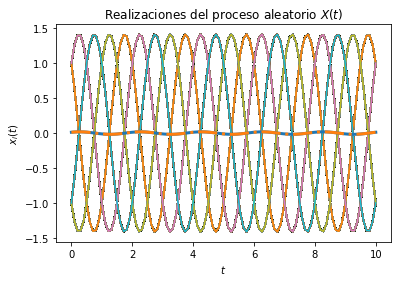

In [2]:
# CÓDIGO 4.2

import numpy as np
from scipy import stats
from scipy.stats import bernoulli
import matplotlib.pyplot as plt

P_Bernoulli = 0.5

# Variables aleatorias X y Y
vaX = bernoulli(P_Bernoulli)
vaY = bernoulli(P_Bernoulli)


# Creación del vector de tiempo
T       = 100			# número de elementos
t_final = 10	# tiempo en segundos
t       = np.linspace(0, t_final, T)


# Inicialización del proceso aleatorio X(t) con N realizaciones
N   = 10000
X_t = np.empty((N, len(t)))	# N funciones del tiempo x(t) con T puntos


# Creación de las muestras del proceso x(t) (X y Y independientes)
for i in range(N):
    X = vaX.rvs()
    if X==0:      # Para los valores de X igual a cero
        X=-1      # Los convertimos en -1
    else:
        X=1       # De otro modo X = 1
        
    Y = vaY.rvs()
    if Y==0:     # Para los valores de Y igual a cero
        Y=-1     # Los convertimos en -1
    else:
        Y=1      # De otro modo Y = 1
        
    x_t = X * np.cos(2*np.pi*fc*t) + Y * np.sin(2*np.pi*fc*t)
    X_t[i,:] = x_t
    plt.plot(t, x_t)
    

# Promedio de las N realizaciones en cada instante (cada punto en t)
PromedioTeorico = [np.mean(X_t[:,i]) for i in range(len(t))]
plt.plot(t, PromedioTeorico, lw=3)

# Graficar el resultado teórico del valor esperado
senal_Tx = [np.mean(X_t[:,i]) for i in range(len(t))]
plt.plot(t, senal_Tx, '-.', lw=3)

# Mostrar las realizaciones, y su promedio calculado y teórico
plt.title('Realizaciones del proceso aleatorio $X(t)$')
plt.xlabel('$t$')
plt.ylabel('$x_i(t)$')
plt.show()


<ipython-input-7-36227cc59e70>:4: DeprecationWarning: Using scipy.fft as a function is deprecated and will be removed in SciPy 1.5.0, use scipy.fft.fft instead.
  senal_f = fft(senal_Tx)


----------
Densidad espectral de potencia para la señal modulada
----------
[1.79077924e+08 5.79900636e+08 2.05178163e+06 ... 4.25394824e+06
 2.05178163e+06 5.79900636e+08]
----------



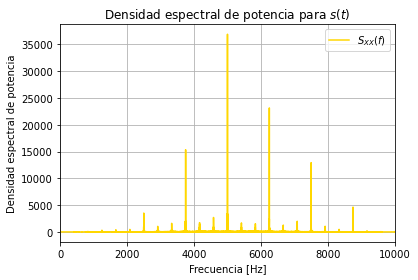

In [7]:
from scipy import fft

# Transformada de Fourier 
senal_f = fft(senal_Tx)

# Muestras de la señal
Nm = len(senal_Tx)

# Número de símbolos (con // entrega un número entero)
#(198 x 89 x 8 x 3)
Ns = Nm // mpp

# Tiempo del símbolo
Ts = 1 / fc

# Tiempo entre muestras (período de muestreo)
Tm = Ts / mpp

# Tiempo de la simulación
T = Ns * Ts

# Espacio de frecuencias
f = np.linspace(0.0, 1.0/(2.0*Tm), Nm//2)

# Densidad espectral de potencia
S_xx = np.power(np.abs(senal_f), 2)

#
print('----------\nDensidad espectral de potencia para la señal modulada\n----------')
print(S_xx)
print('----------\n')

# Gráfica
plt.plot(f, 2.0/Nm * np.power(np.abs(senal_f[0:Nm//2]), 2), color = 'gold' , label='$S_{XX}(f)$')
plt.xlim(0, 10000)
plt.title('Densidad espectral de potencia para $s(t)$')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Densidad espectral de potencia')
plt.legend()
plt.grid()
plt.show()

